In [5]:
import os
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import utils_plots as ut

In [6]:
# 'NEP'
# f'test60_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test78_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test87_linreg_nc{n_clusters}_nv8_nd9_noTS'
# 'NWP'
# f'test4_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test25_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test83_linreg_nc{n_clusters}_nv8_nd9_noTS'
# 'NA'
# f'test3_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test14_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test61_linreg_nc{n_clusters}_nv8_nd9_noTS'
# 'NI'
# f'test26_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test32_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test45_linreg_nc{n_clusters}_nv8_nd9_noTS'
# 'SI'
# f'test12_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test51_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test82_linreg_nc{n_clusters}_nv8_nd9_noTS'
# 'SP'
# f'test8_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test23_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test98_linreg_nc{n_clusters}_nv8_nd9_noTS'

In [7]:
basin = 'NEP'
perc = 70
n_clusters_dict = {'NEP': 9, 'NWP': 8, 'NA': 12, 'NI': 9, 'SI': 10, 'SP': 11}
n_clusters = n_clusters_dict[basin]
run_name = f'selfeat{perc}_top20_nc{n_clusters}_nv8_nd9_noTS'
# run_name = f'test60_linreg_nc{n_clusters}_nv8_nd9_noTS'

In [8]:
# Set years range and number of folds
years = np.arange(1980, 2022, 1) # from 1980 to 2021 included
n_folds = 3
# Set directories and file paths, then load file containing predictors and target
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'FS_TCG')
cluster_data = f'{basin}_{n_clusters}clusters_noTS'
cluster_data_dir = os.path.join(fs_dir, 'data', cluster_data)
# predictors
predictor_file = f'predictors_1980-2022_{n_clusters}clusters_8vars_9idxs.csv'
predictors_df = pd.read_csv(os.path.join(cluster_data_dir, predictor_file), index_col=0)
predictors_df.index = pd.to_datetime(predictors_df.index)
predictors_df = predictors_df.loc[predictors_df.index.year.isin(years)]
# target
target_file = 'target_residual_1980-2022_2.5x2.5.csv'
seasonal_file = 'target_seasonality_1980-2022_2.5x2.5.csv'
trend_file = 'target_trend_1980-2022_2.5x2.5.csv'
target_df = pd.read_csv(os.path.join(cluster_data_dir, target_file), index_col=0)
target_df.index = pd.to_datetime(target_df.index)
target_df = target_df.loc[target_df.index.year.isin(years)]
target_season_df = pd.read_csv(os.path.join(cluster_data_dir, seasonal_file), index_col=0)
target_season_df.index = pd.to_datetime(target_season_df.index)
target_season_df = target_season_df.loc[target_season_df.index.year.isin(years)]
target_trend_df = pd.read_csv(os.path.join(cluster_data_dir, trend_file), index_col=0)
target_trend_df.index = pd.to_datetime(target_trend_df.index)
target_trend_df = target_trend_df.loc[target_trend_df.index.year.isin(years)]
# gpis
gpis_file = f'{basin}_2.5x2.5_gpis_time_series.csv'
gpis_path = os.path.join(fs_dir, 'data', gpis_file)
gpis_df = pd.read_csv(gpis_path, index_col=0)
gpis_df.index = pd.to_datetime(gpis_df.index)
gpis_df = gpis_df.loc[gpis_df.index.year.isin(years)]
# Get the run info and data
Y_pred, Y_pred_noFS, X_test_eval, X_test_eval_noFS, mlps, mlps_noFS, perm_importance_mlp, perm_importance_mlp_noFS, shap_values_mlp, shap_values_mlp_noFS = ut.runs_info(basin, run_name)
# Convert list of dataframes to a single dataframe
X_test = pd.concat(X_test_eval)
X_test_noFS = pd.concat(X_test_eval_noFS)
Y_pred_df = pd.concat(Y_pred)
Y_pred_noFS_df = pd.concat(Y_pred_noFS)

2025-03-26 13:25:32.067416: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-03-26 13:25:32.067443: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-03-26 13:25:32.067447: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-03-26 13:25:32.067479: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-26 13:25:32.067493: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-03-26 13:25:32.334343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


**Time series Trajectories and Metrics**

In [9]:
# Target with trend and seasonality
target_df_TS = target_df['resid'] + target_trend_df['trend'] + target_season_df['season']
# Predictions with trend and seasonality
Y_pred_df_TS = Y_pred_df['resid'] + target_trend_df['trend'] + target_season_df['season']
Y_pred_noFS_df_TS = Y_pred_noFS_df['resid'] + target_trend_df['trend'] + target_season_df['season']
Y_pred_df_TS[Y_pred_df_TS < 0] = 0.0
Y_pred_noFS_df_TS[Y_pred_noFS_df_TS < 0] = 0.0
# Annual data without trend and seasonality
target_df_annual = target_df.groupby(target_df.index.year).sum()
Y_pred_df_annual = Y_pred_df.groupby(Y_pred_df.index.year).sum()
Y_pred_noFS_df_annual = Y_pred_noFS_df.groupby(Y_pred_noFS_df.index.year).sum()
# Annual data with trend and seasonality
target_df_annual_TS = target_df_TS.groupby(target_df_TS.index.year).sum()
Y_pred_df_annual_TS = Y_pred_df_TS.groupby(Y_pred_df_TS.index.year).sum()
Y_pred_noFS_df_annual_TS = Y_pred_noFS_df_TS.groupby(Y_pred_noFS_df_TS.index.year).sum()
# GPIs time series with trend and seasonality
engpi_TS = gpis_df['engpi']
ogpi_TS = gpis_df['ogpi']
# GPIs time series without trend and seasonality
decomp_engpi = STL(engpi_TS).fit()
trend_engpi = decomp_engpi.trend
seasonal_engpi = decomp_engpi.seasonal
engpi = decomp_engpi.resid
decomp_ogpi = STL(ogpi_TS).fit()
trend_ogpi = decomp_ogpi.trend
seasonal_ogpi = decomp_ogpi.seasonal
ogpi = decomp_ogpi.resid
# Annual data of the GPIs
engpi_annual = engpi.groupby(engpi.index.year).sum()
ogpi_annual = ogpi.groupby(ogpi.index.year).sum()
engpi_annual_TS = engpi_TS.groupby(engpi_TS.index.year).sum()
ogpi_annual_TS = ogpi_TS.groupby(ogpi_TS.index.year).sum()
# Compute the correlation coefficient and the MSE between the predictions and the test values
# Monthly without trend and seasonality
r, _ = pearsonr(target_df['resid'], Y_pred_df['resid'])
r_noFS, _ = pearsonr(target_df['resid'], Y_pred_noFS_df['resid'])
r_engpi, _ = pearsonr(target_df['resid'], engpi)
r_ogpi, _ = pearsonr(target_df['resid'], ogpi)
mse = mean_squared_error(target_df['resid'], Y_pred_df['resid'])
mse_noFS = mean_squared_error(target_df['resid'], Y_pred_noFS_df['resid'])
mse_engpi = mean_squared_error(target_df['resid'], engpi)
mse_ogpi = mean_squared_error(target_df['resid'], ogpi)
# Monthly with trend and seasonality
r_TS, _ = pearsonr(target_df_TS, Y_pred_df_TS)
r_noFS_TS, _ = pearsonr(target_df_TS, Y_pred_noFS_df_TS)
r_engpi_TS, _ = pearsonr(target_df_TS, engpi_TS)
r_ogpi_TS, _ = pearsonr(target_df_TS, ogpi_TS)
mse_TS = mean_squared_error(target_df_TS, Y_pred_df_TS)
mse_noFS_TS = mean_squared_error(target_df_TS, Y_pred_noFS_df_TS)
mse_engpi_TS = mean_squared_error(target_df_TS, engpi_TS)
mse_ogpi_TS = mean_squared_error(target_df_TS, ogpi_TS)
# Annual without trend and seasonality
rY, _ = pearsonr(target_df_annual['resid'], Y_pred_df_annual['resid'])
rY_noFS, _ = pearsonr(target_df_annual['resid'], Y_pred_noFS_df_annual['resid'])
rY_engpi, _ = pearsonr(target_df_annual['resid'], engpi_annual)
rY_ogpi, _ = pearsonr(target_df_annual['resid'], ogpi_annual)
mseY = mean_squared_error(target_df_annual['resid'], Y_pred_df_annual['resid'])
mseY_noFS = mean_squared_error(target_df_annual['resid'], Y_pred_noFS_df_annual['resid'])
mseY_engpi = mean_squared_error(target_df_annual['resid'], engpi_annual)
mseY_ogpi = mean_squared_error(target_df_annual['resid'], ogpi_annual)
# Annual with trend and seasonality
rY_TS, _ = pearsonr(target_df_annual_TS, Y_pred_df_annual_TS)
rY_noFS_TS, _ = pearsonr(target_df_annual_TS, Y_pred_noFS_df_annual_TS)
rY_engpi_TS, _ = pearsonr(target_df_annual_TS, engpi_annual_TS)
rY_ogpi_TS, _ = pearsonr(target_df_annual_TS, ogpi_annual_TS)
mseY_TS = mean_squared_error(target_df_annual_TS, Y_pred_df_annual_TS)
mseY_noFS_TS = mean_squared_error(target_df_annual_TS, Y_pred_noFS_df_annual_TS)
mseY_engpi_TS = mean_squared_error(target_df_annual_TS, engpi_annual_TS)
mseY_ogpi_TS = mean_squared_error(target_df_annual_TS, ogpi_annual_TS)

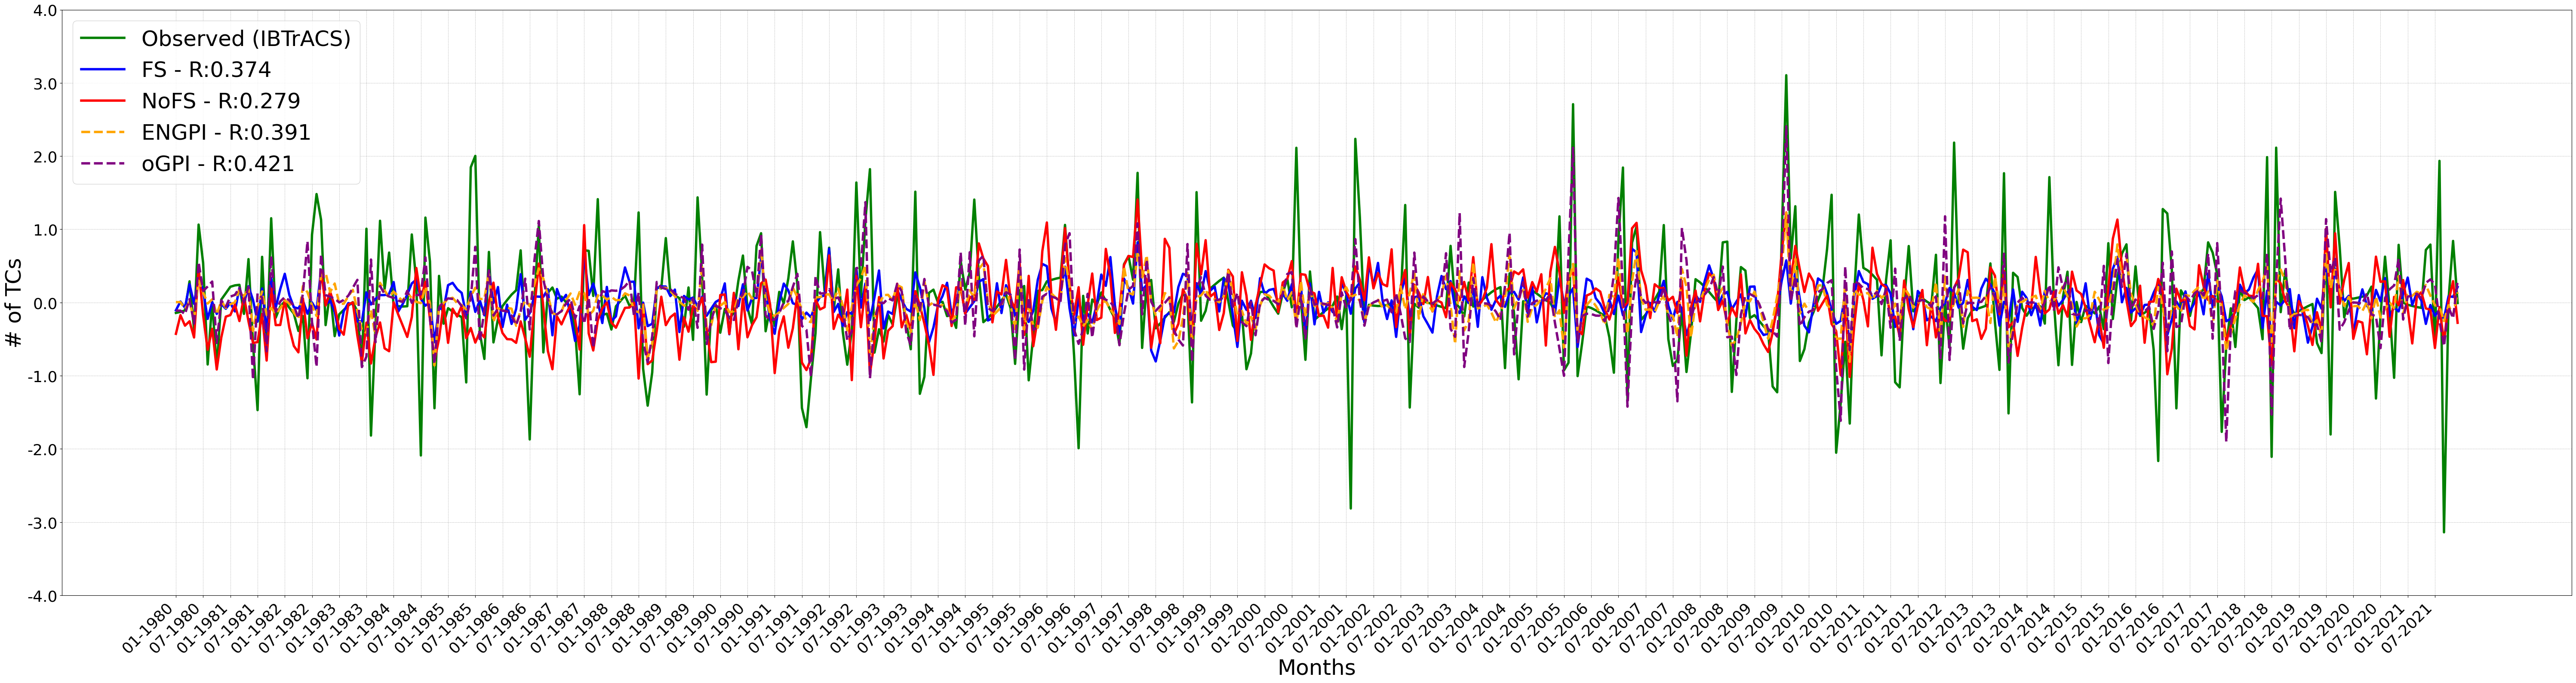

In [10]:
# Plotting the monthly time series detrended and deseasonalized
fig_ts = ut.plot_monthly_time_series(target_df['resid'], Y_pred_df['resid'], Y_pred_noFS_df['resid'], engpi, ogpi, r, r_noFS, r_engpi, r_ogpi)
# Plotting the montly time series with trend and seasonality
# fig_ts_TS = ut.plot_monthly_time_series(target_df_TS, Y_pred_df_TS, Y_pred_noFS_df_TS, engpi_TS, ogpi_TS, r_TS, r_noFS_TS, r_engpi_TS, r_ogpi_TS)

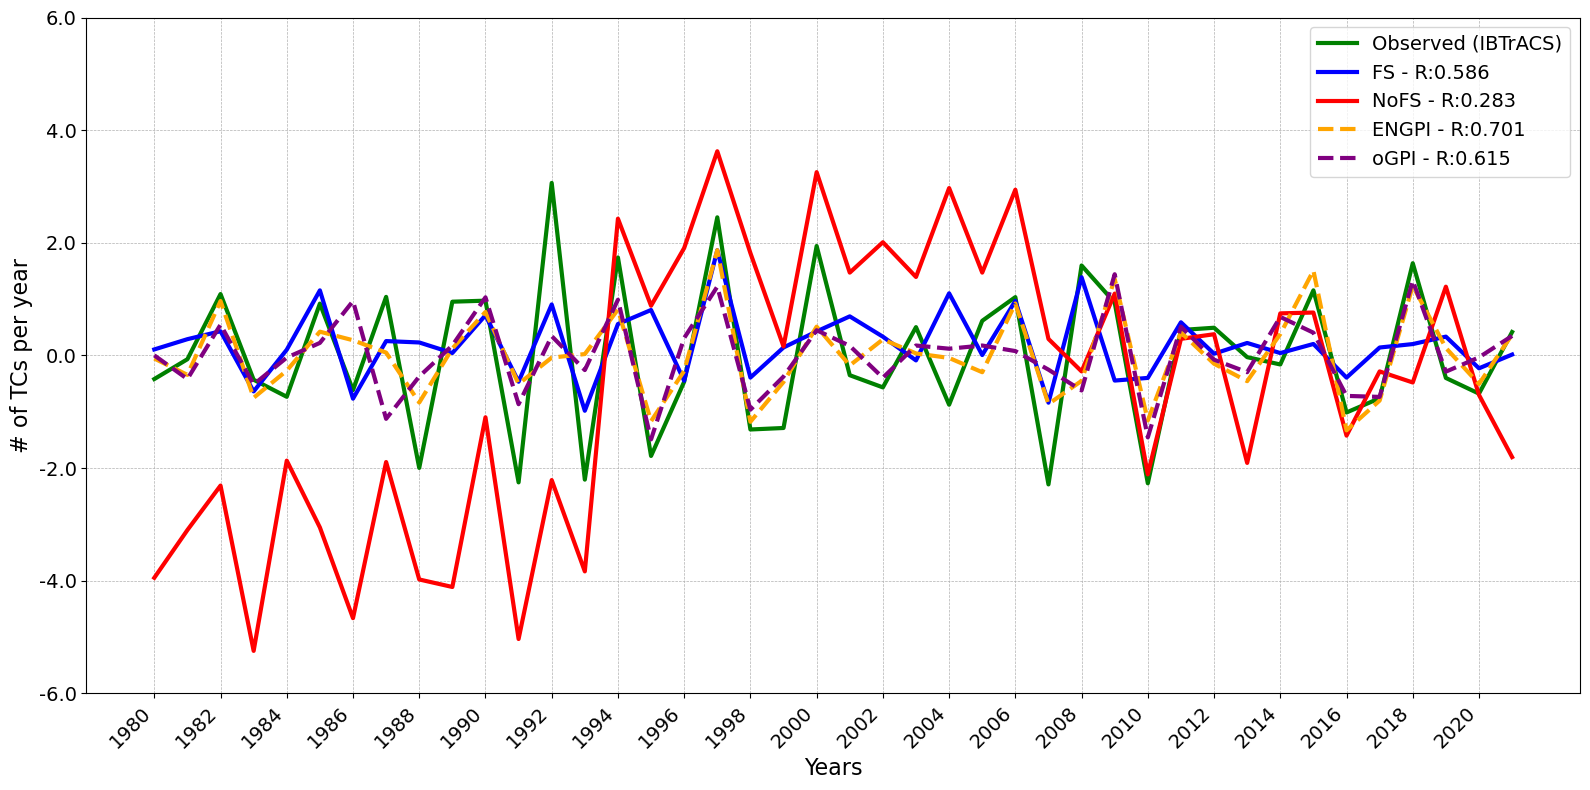

In [11]:
# Plotting the annual time series detrended and deseasonalized
fig_annual = ut.plot_annual_time_series(target_df_annual['resid'], Y_pred_df_annual['resid'], Y_pred_noFS_df_annual['resid'], engpi_annual, ogpi_annual, rY, rY_noFS, rY_engpi, rY_ogpi)
# Plotting the annual time series with trend and seasonality
# fig_annual_TS = ut.plot_annual_time_series(target_df_annual_TS, Y_pred_df_annual_TS, Y_pred_noFS_df_annual_TS, engpi_annual_TS, ogpi_annual_TS, rY_TS, rY_noFS_TS, rY_engpi_TS, rY_ogpi_TS)

**Selected Features**

In [12]:
# Determine selected features according to the run_name
if 'selfeat' in run_name:
    perc = run_name.split('_top20')[0].split('selfeat')[1]
    csv_path = os.path.join(fs_dir, 'results', f'selected_features_best_models_{basin}_{n_clusters}_noTS.csv')
    df_perc_sel = pd.read_csv(csv_path, index_col=0)
    selected_features = df_perc_sel[str(perc)].dropna().to_list()
elif 'test' in run_name:
    experiment_filename = f'1980-2022_{n_clusters}clusters_8vars_9idxs.csv'
    sol_filename = 'linreg_' + experiment_filename
    output_dir = os.path.join(fs_dir, 'results', basin, run_name)
    best_sol_path = os.path.join(output_dir, f'best_solution_{sol_filename}')
    best_solution = pd.read_csv(best_sol_path, sep=',', header=None)
    best_solution = best_solution.to_numpy().flatten()
    column_names = predictors_df.columns.tolist()
    final_sequence = best_solution[len(column_names):2*len(column_names)]
    sequence_length = best_solution[:len(column_names)]
    feat_sel = best_solution[2*len(column_names):]
    variable_selection = feat_sel.astype(int)
    time_sequences = sequence_length.astype(int)
    time_lags = final_sequence.astype(int)
    selected_features = []
    for c, col in enumerate(predictors_df.columns):
        if variable_selection[c] == 0 or time_sequences[c] == 0:
            continue
        for j in range(time_sequences[c]):
            selected_features.append(str(col))
else:
    raise ValueError(f'Unknown run name: {run_name}')
# Get the variables names and the selected clusters
variables_with_cluster = [var for var in selected_features if 'cluster' in var]
variables_without_cluster = [var for var in selected_features if 'cluster' not in var]
variable_names_cluster = [var.split('_cluster')[0] for var in variables_with_cluster]
variable_names_cluster = list(set(variable_names_cluster))
variable_names_cluster.sort()

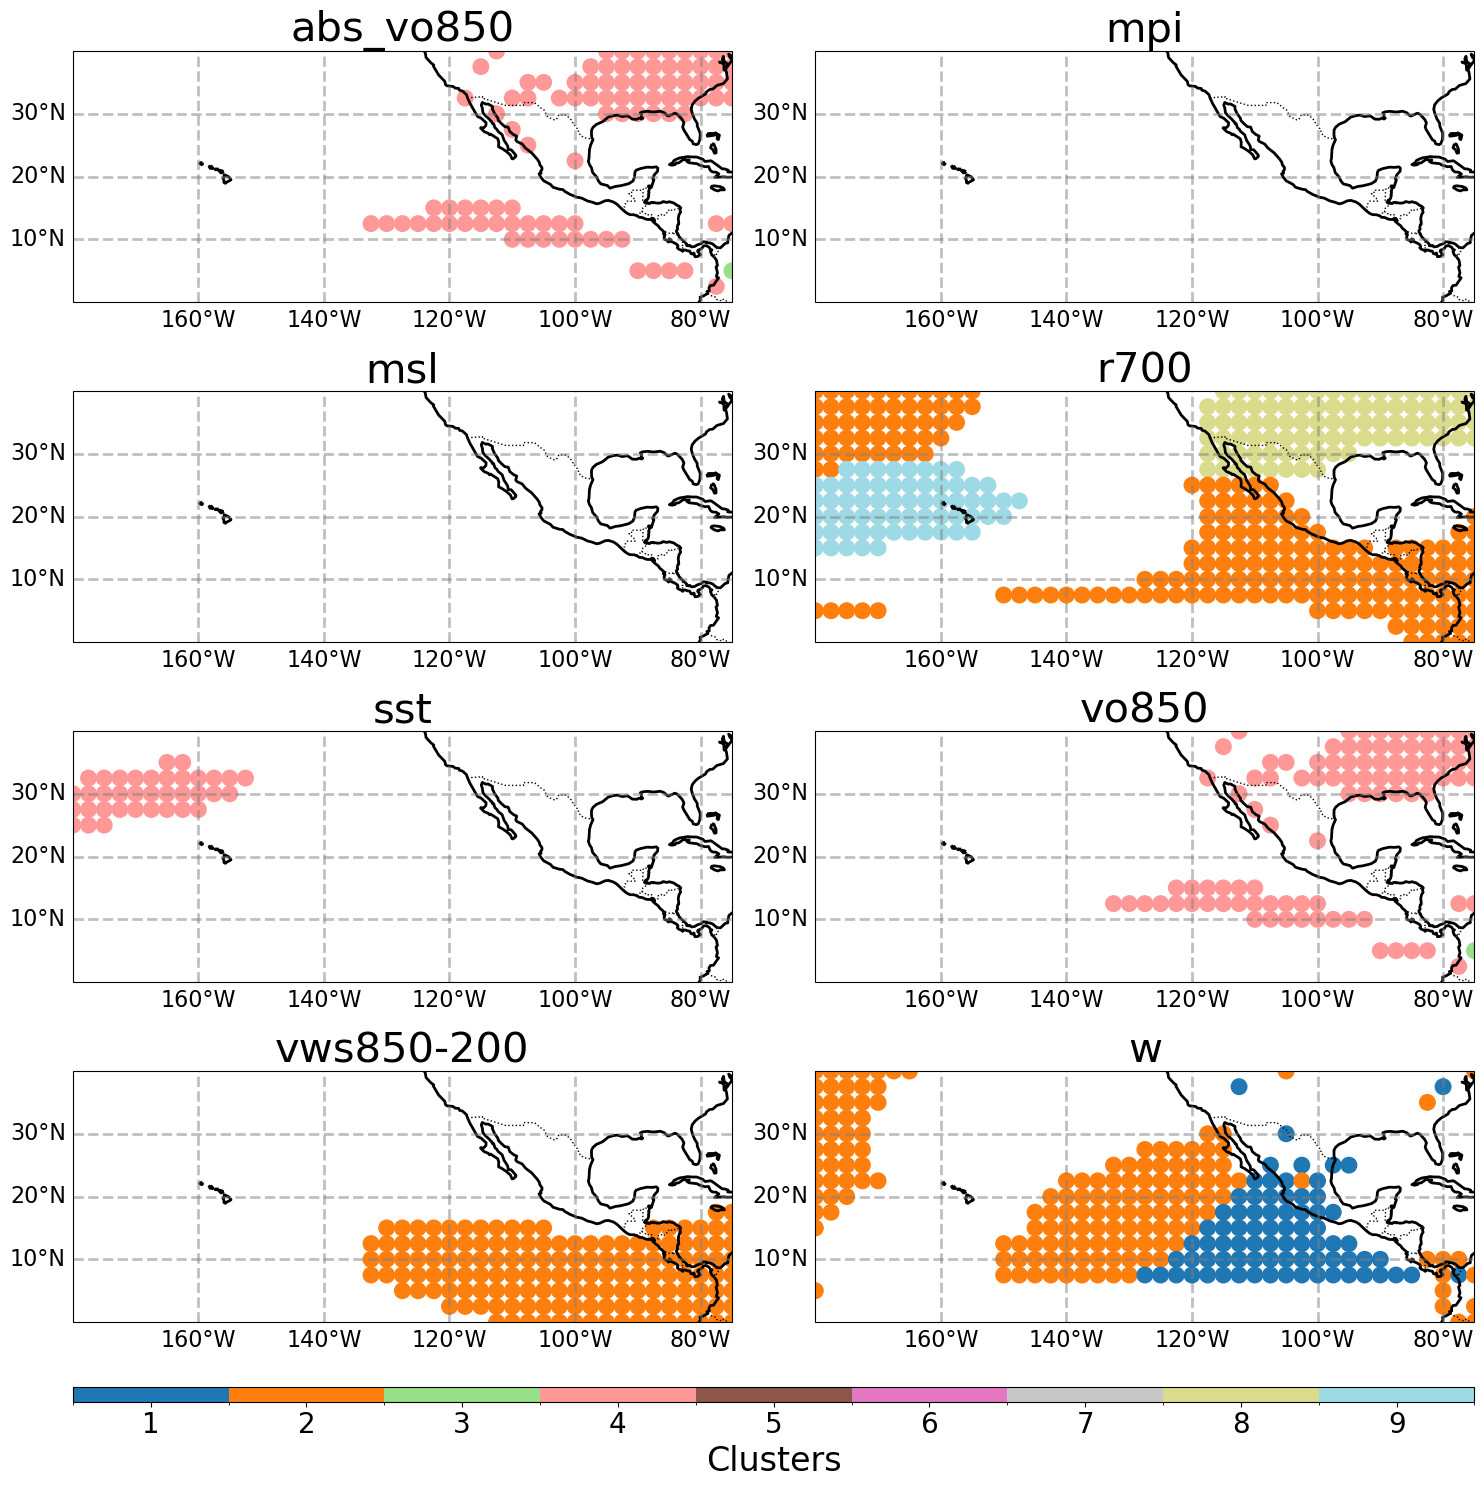

In [13]:
fig_clusters = ut.plot_variables_clusters(basin, n_clusters, cluster_data_dir, variable_names_cluster, selected_features)

**Print lines for LaTEX table**

In [14]:
# print(f'& FS-NN & {mse:.3f} & {r:.3f} & {mseS:.3f} & {rS:.4f} & {mseY:.3f} & {rY:.3f} \\\\')
# print(f'~ & NN & {mse_noFS:.3f} & {r_noFS:.3f} & {mseS_noFS:.3f} & {rS_noFS:.4f} & {mseY_noFS:.3f} & {rY_noFS:.3f} \\\\')
# print(f'~ & ENGPI & {mse_engpi:.3f} & {r_engpi:.3f} & {mseS_engpi:.3f} & {rS_engpi:.4f} & {mseY_engpi:.3f} & {rY_engpi:.3f} \\\\')
# print(f'~ & oGPI & {mse_ogpi:.3f} & {r_ogpi:.3f} & {mseS_ogpi:.3f} & {rS_ogpi:.4f} & {mseY_ogpi:.3f} & {rY_ogpi:.3f} \\\\')

**SHAP values**

In [18]:
Y_pred_df_annual

,resid
1980,0.105609
1981,0.287899
1982,0.428782
1983,-0.639688
1984,0.101018
1985,1.154839
1986,-0.768609
1987,0.254080
1988,0.229611
1989,0.042267


In [ ]:
## Set different parameters for following plots ##
years_couples = []
# Create a DataFrame with fold number corresponding to each year and also the couple of max and min years for each fold
kfold = KFold(n_splits=n_folds)
test_years_df = pd.DataFrame(0, index=years, columns=['fold'])
for nf, (train_index, test_index) in enumerate(kfold.split(years)):
    test_years_df.loc[years[test_index], 'fold'] = nf
    Y_pred_df_annual_fold = Y_pred_df_annual.loc[years[test_index]]
    max_fold = Y_pred_df_annual_fold['resid'].idxmax()
    min_fold = Y_pred_df_annual_fold['resid'].idxmin()
    years_couples.append((max_fold, min_fold))

1985 1993
1997 2007
2008 2009


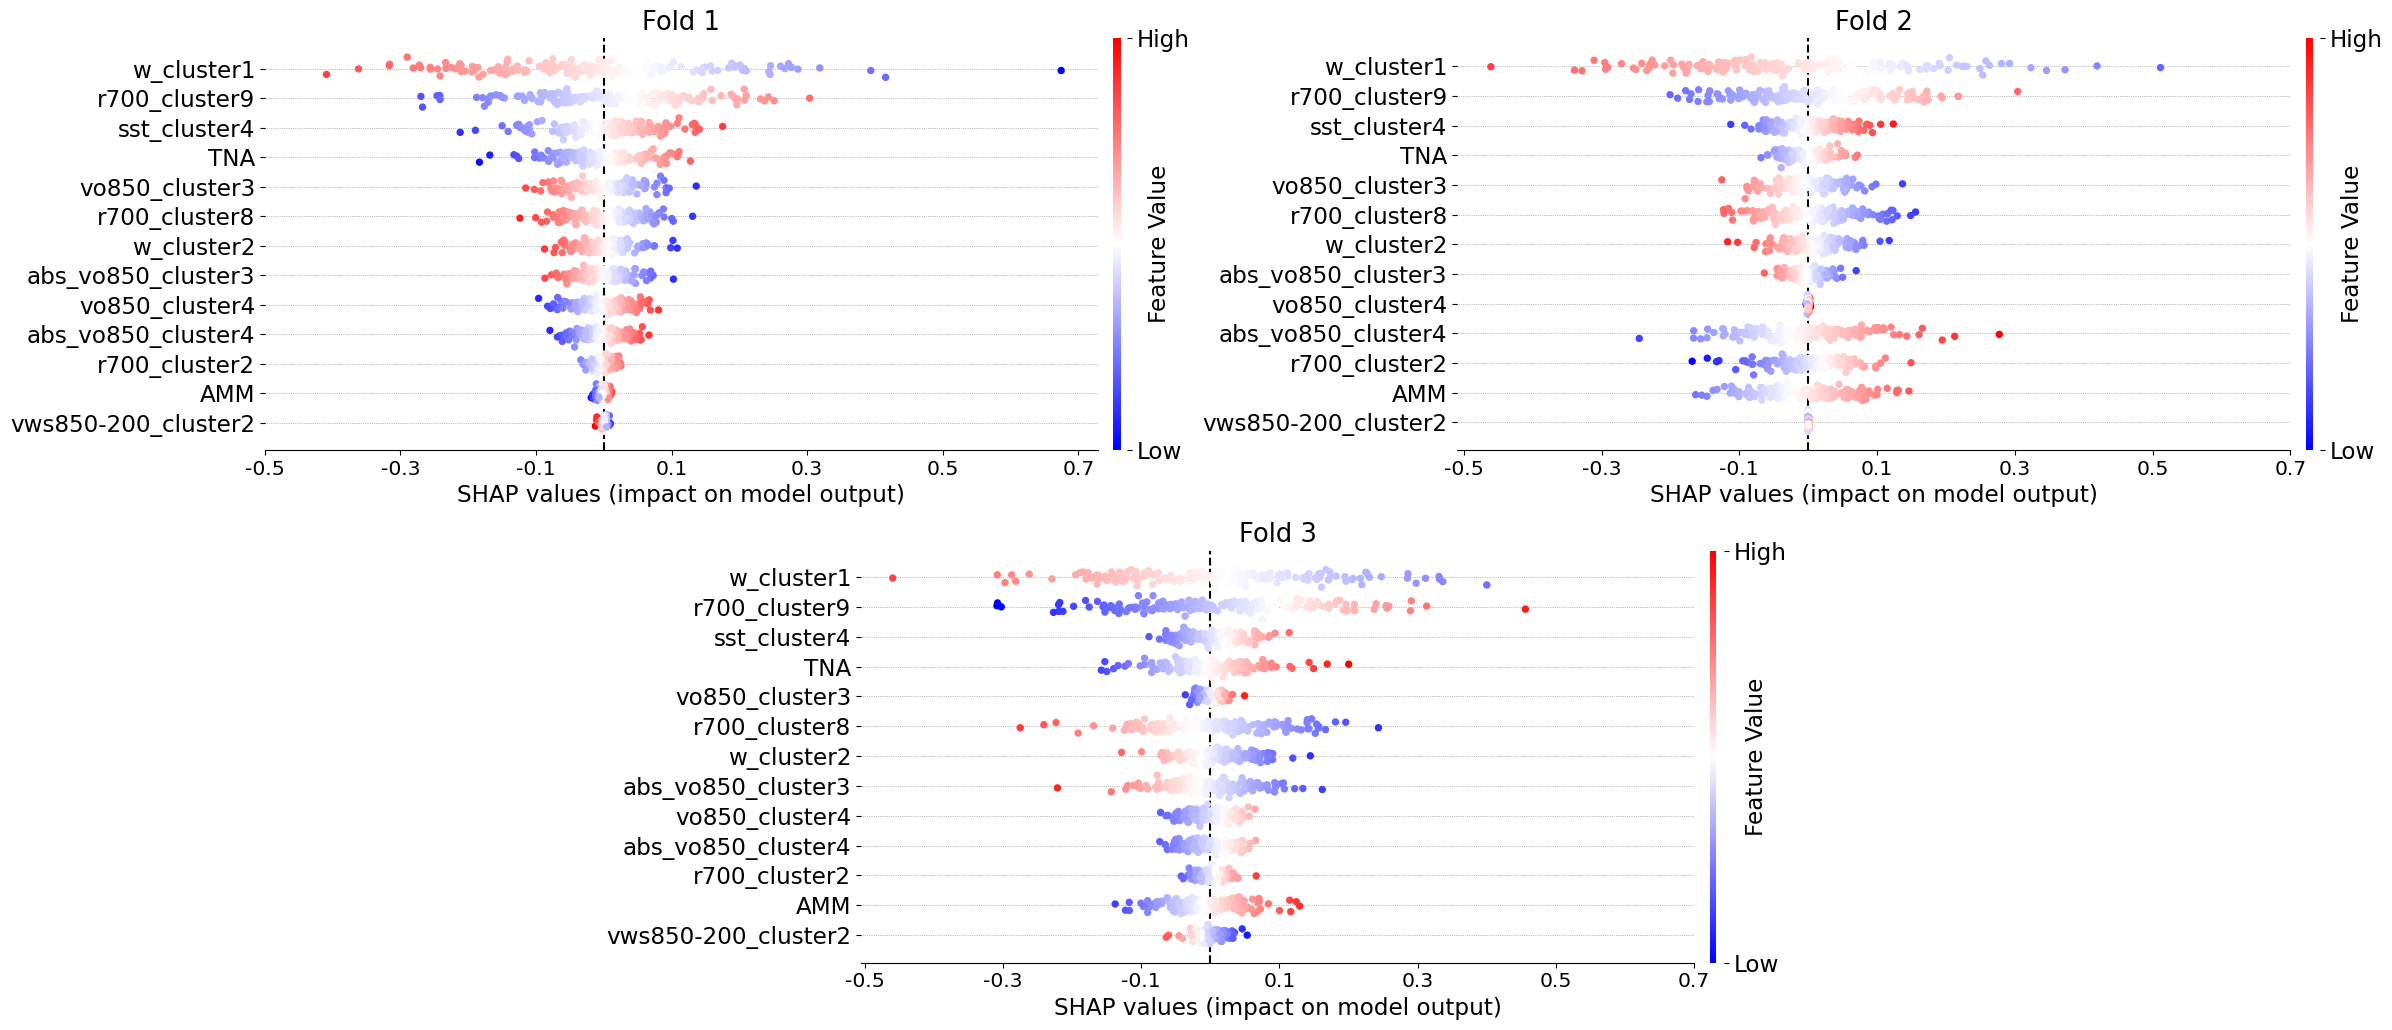

In [16]:
fig_shap = ut.plot_shap_values(shap_values_mlp)

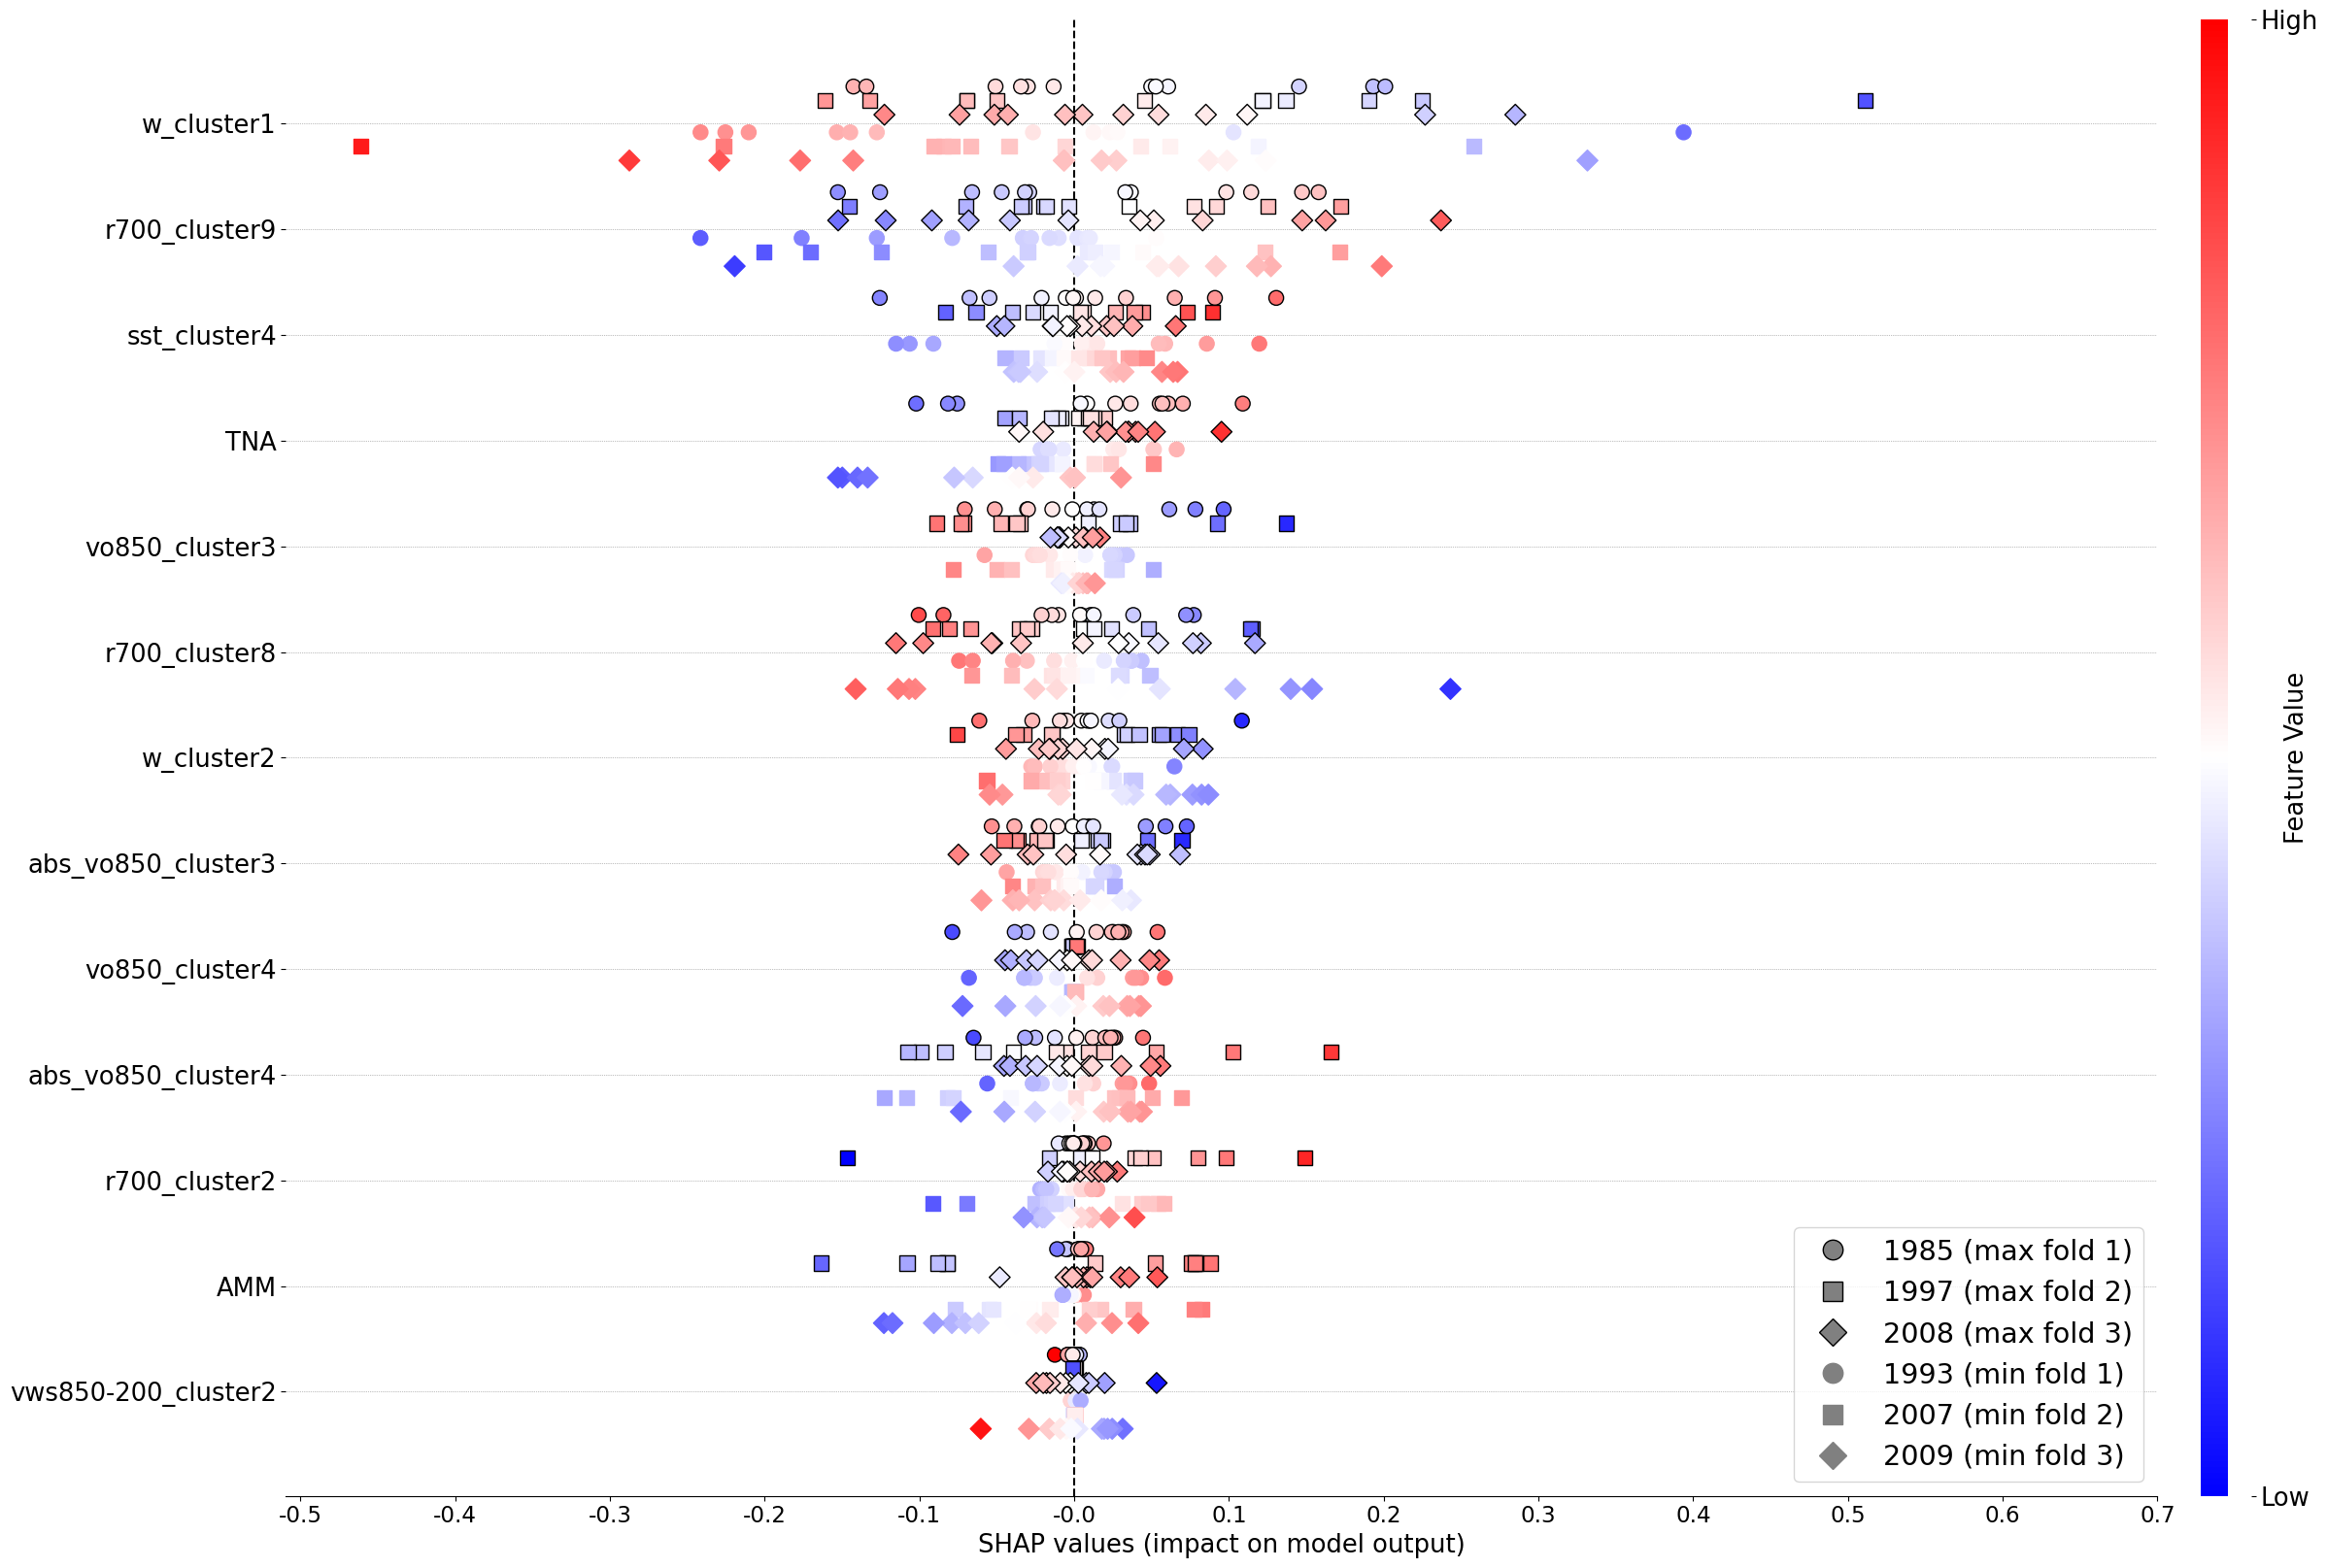

In [ ]:
fig_shap_minmax = ut.plot_minmax_shap_values(shap_values_mlp, years_couples, Y_pred, test_years_df)